# Imports

In [3]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pulp as pl
import seaborn as sns

from copy import deepcopy
from itertools import chain
from tqdm import tqdm
import logging
import time

logger = logging.getLogger(__name__)

In [5]:
pl.listSolvers(onlyAvailable=True)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 915570
Academic license - for non-commercial use only - registered to pascal.quach@etu.utc.fr
No parameters matching '_test' found


['GUROBI', 'PULP_CBC_CMD']

# Path Generation

## Problem formulation

_N.B.: In the following paragraph, we consider all paths to be simple paths, i.e. a sequence of edges visiting each of its nodes only once._

We consider a network with:
- $\mathcal{V}$, a set of nodes
- $\mathcal{E}$, a set of directed edges with nonnegative capacities $C_e$, for each edge $e\in \mathcal{E}$
- $d$, a connection/demand, with predefined path set $\mathcal{P}_d$ between nodes $s_d$ and $t_d$
- Any path $p$ is represented by a set of edges, i.e. $p\subseteq \mathcal{E}$

We denote by $x_p$ the flow allocated to a path $p\in \mathcal{P}_d$, and $\pi_e$ the associated dual variables of our problem formulation.

A flow $x_p$ is feasible, if it does not exceed the capacities $C_e$ of its edges. 
That is, for an edge $e\in\mathcal{E}$, the sum of all flows that include edge $e$ must not exceeed its capacity $C_e$
$$
\sum_{p\in \mathcal{P}_d, e\in p} x_p \leq C_e
$$


**We wish to find feasible flows for each path that maximizes the sum of all flows $\sum_{p\in \mathcal{P}_d} x_p$, i.e. the maximum flow problem formulated through path variables instead of flow variables on edges.**

$$
\begin{aligned}
\max & \sum_{p\in \mathcal{P}_d} x_p\\
\text{s.t.} & \sum_{p\in \mathcal{P}_d, e\in p} x_p \leq C_e,\quad \forall e\in \mathcal{E}\, (\pi_e)\\
& x_p \geq 0,\quad p\in \mathcal{P}_d
\end{aligned}
$$

We use the column generation algorithm to build paths to join the set $\mathcal{P}_d$.

For any given path $q\in D$, with $D$ the columns out of the optimal basis $B$, we wish to maximize the reduced cost 
$$
C_D - C_B B^{-1}D = 1 - \sum_{e\in q} \pi_e,
$$
i.e., minimizing $\sum_{e\in q} \pi_e$, that is finding the shortest path $q$ weighted with $\pi$.

_N.B.: The problem of maximum flow is equivalent to maximum path generation **if we consider all possible paths** instead of $\mathcal{P}_d$._

In this way, we can iteratively add paths to our initial set $\mathcal{P}_d$ until the solution given by the master problem is optimal, i.e. the reduced cost is negative:

1. Initialise the master problem (MP) with a set $\mathcal{P}_d$ containing paths from $s_d$ to $t_d$
2. Solve (MP) and note the obtained dual variables $\pi$
3. Compute the shortest path $q$ from $s_d$ to $t_d$
4. Compute the reduced cost $r_q=1 - \sum_{e\in q}\pi_e$
    1. If $r_q \geq 0$, then add $q$ to $\mathcal{P}_d$, and continue from 2)
    2. Otherwise, stop. The solution is optimal

## Iterative procedure

1. Density is the proportion of edges in a full connected graph. A dense graph has $n(n-1)$ edges where $n$ is the number of nodes
2. `maximum_flow` from networkx has a linear trend w.r.t. the graph density

In [6]:
def get_graphs(
    min_capacity: int,
    max_capacity: int,
    n_nodes: int,
    n_edges: int,
) -> tuple[nx.DiGraph, nx.DiGraph]:
    """Initialize random graph with capacity."""
    if min_capacity < 0:
        raise ValueError("Minimum capacity cannot be negative")
    elif min_capacity > max_capacity:
        raise ValueError("Minimum capacity is above maximum capacity")

    graph = nx.gnm_random_graph(n_nodes, n_edges, directed=True)
    dual_graph = deepcopy(graph)

    for (u, v) in graph.edges():
        graph.edges[u, v]["capacity"] = np.random.uniform(min_capacity, max_capacity)

    return graph, dual_graph

In [221]:
def get_n_simple_paths(
    graph: nx.DiGraph,
    source: int,
    destination: int,
    max_n_paths: int = 16,
) -> list[list[tuple[int, int]]]:
    """Get max_iter simple paths from source to destination."""
    simple_paths = []
    gen = nx.all_simple_edge_paths(graph, source, destination, cutoff=0.1 * len(graph))
    while len(simple_paths) < max_n_paths:
        simple_paths.append(next(gen))

    return simple_paths

In [223]:
def master_problem(
    graph: nx.DiGraph,
    max_capacity: int,
    paths: list[list[tuple[int, int]]],
) -> pl.LpProblem:
    """Initialise the master problem.

    1. Add path variables
    2. Iteratively add capacity constraints

    Args:
        graph: graph of the problem instance
        max_capacity: to give an upperbound to the LpVariables
        paths: initial paths set $\mathcal{P}_d$
    """
    # Initialise master problem
    lpProb = pl.LpProblem(
        name="PathGeneration",
        sense=pl.LpMaximize,
    )

    # For every path add one variable
    path_variables = [
        pl.LpVariable(
            name="X" + str(i),
            lowBound=0,
            upBound=max_capacity,
            cat=pl.LpContinuous,
        )
        for i in range(len(paths))
    ]

    # Add variables with weight 1 to the objective
    lpProb += 0
    for var in path_variables:
        lpProb.objective.addterm(var, 1)

    # Add capacities constraints
    unique_edges = set(list(chain(*paths)))
    for edge in unique_edges:
        variables = [
            path_var for path, path_var in zip(paths, path_variables) if edge in path
        ]
        lpProb.constraints[str(edge)] = sum(variables) <= graph.edges[edge]["capacity"]

    return lpProb

In [252]:
def add_paths(
    lpProb: pl.LpProblem,
    graph: nx.DiGraph,
    path_set: list[list[tuple[int, int]]],
    new_path: list[tuple[int, int]],
    max_capacity: int,
):
    """Add new variable and constraint associated with new path.

    Args:
        lpProb: master problem
        graph: graph of the problem instance
        path_set: existing paths in the LP problem
        new_path: new path to add to the formulation
        max_capacity: maximum edge capacity to bound the variable
    """
    # Add new variable and update objective function
    var = pl.LpVariable(
        name="X" + str(len(lpProb.variables())),
        lowBound=0,
        upBound=max_capacity,
        cat=pl.LpContinuous,
    )
    lpProb.objective.addterm(var, 1)

    # Add new constraints
    for edge in new_path:
        if str(edge) in lpProb.constraints:
            # Edge is already constrained, simply add the new variable
            lpProb.constraints[str(edge)].addterm(var, 1)
        else:
            # Edge is not constrained, check all other existing paths
            # to create the new constraint
            variables = [
                path_var
                for path, path_var in zip(path_set, lpProb.variables())
                if edge in path
            ] + [var]
            lpProb.constraints[str(edge)] = (
                sum(variables) <= graph.edges[edge]["capacity"]
            )

    return lpProb

In [253]:
def str_to_tuple_int(val: str) -> tuple[int, int]:
    a, b = val.split(",")
    return int(a[1:]), int(b[1:-1])

In [254]:
def get_duals(lpProb: pl.LpProblem) -> dict[tuple[int, int], float]:
    """Get the dual variables from PuLP LP problem.

    Notes
        Dual values are rounded to avoid small negative values.
    """
    return {
        str_to_tuple_int(name): np.around(c.pi, 8)
        for name, c in lpProb.constraints.items()
    }

In [255]:
def reset_weights_graph(
    graph: nx.DiGraph,
    new_weights: dict[tuple[int, int], float],
) -> None:
    """Utility function for setting weights."""
    # Reset weight
    nx.set_edge_attributes(
        graph,
        values=0,
        name="weight",
    )
    # Set new weights
    nx.set_edge_attributes(
        graph,
        values=new_weights,
        name="weight",
    )

In [349]:
def path_generation(
    min_capacity: int,
    max_capacity: int,
    n_nodes: int,
    n_edges: int,
    source: int,
    destination: int,
    n_initial_paths: int,
    precision: int = 2,
    max_iter: int = 100,
    solver: pl.LpSolver = None,
    graph: nx.DiGraph = None,
    max_flow: bool = False,
):
    """Iteratively solve the master problem using path generation."""
    # Initialisations
    logger.info(
        f"Generating the graph instance: "
        f"{n_nodes} nodes, {n_edges} edges, "
        f"edge capacities: [{min_capacity}, {max_capacity}]"
    )
    if not graph:
        graph, dual_graph = get_graphs(min_capacity, max_capacity, n_nodes, n_edges)
    else:
        dual_graph = deepcopy(graph)

    if max_flow:
        max_flow = round(nx.maximum_flow_value(graph, 0, 1), precision)
        logger.info(f"Maximum flow from networkx: {max_flow:.2f}")

    if not solver:
        logger.info("Using default solver PULP_CBC_CMD")
        solver = pl.PULP_CBC_CMD(msg=False)

    logger.info(f"Initialising path set with {n_initial_paths} path(s).")
    path_set = get_n_simple_paths(
        graph, source, destination, max_n_paths=n_initial_paths
    )

    logger.info("Initialising master problem")
    lpProb = master_problem(
        graph=graph,
        max_capacity=max_capacity,
        paths=path_set,
    )

    # Solve the MP
    logger.info("Solving MP for the first time")
    lpProb.solve(solver)

    logger.info(f"Current objective value: {lpProb.objective.value():.2f}")

    # Iterations
    logger.info("Beginning path generation")
    reduced_cost = np.array([1])
    if max_flow:
        total = max_flow
    else:
        total = np.nan
    with tqdm(total=None) as pbar:
        counter = 0
        while reduced_cost[-1] > 0:
            # Shortest path q from source to destination, weighted by dual values
            duals = get_duals(lpProb)
            reset_weights_graph(dual_graph, duals)
            try:
                path_q_gen = nx.all_shortest_paths(
                    dual_graph, source, destination, weight="weight"
                )
            except ValueError as e:
                print("SHORTEST PATH ERROR")
                print(e)
                return lpProb, None, None

            # Select one path not in path_set
            for path_q in path_q_gen:
                if path_q not in path_set:
                    path_q = list(zip(path_q[:-1], path_q[1:]))
                    break
                else:
                    raise ValueError("No candidate shortest path")

            # Compute reduced cost for path q
            reduced_cost = np.append(
                reduced_cost,
                1
                - np.sum(
                    [
                        lpProb.constraints[str(edge)].pi
                        for edge in path_q
                        if str(edge) in lpProb.constraints
                    ]
                ),
            )

            # Check stop condition
            if reduced_cost[-1] > 0:
                # Add constraint associated with path q to LP Problem
                lpProb = add_paths(
                    lpProb=lpProb,
                    graph=graph,
                    path_set=path_set,
                    new_path=path_q,
                    max_capacity=max_capacity,
                )

                # Update path set
                path_set.append(path_q)
                del path_q

                # Solve the problem again
                lpProb.solve(solver)

            # Update progress bar
            obj_value = round(lpProb.objective.value(), precision)
            pbar.update(obj_value - pbar.n)
            pbar.set_description(
                f"({graph}) "
                f"Path generation n°{counter} | "
                f"Reduced cost: {reduced_cost[-1]:.2f} | "
                f"Objective value: {obj_value:.2f} | "
                f"Networkx max. flow: {total:.2f}"
            )

            # Check max iteration
            counter += 1
            if counter == max_iter:
                break

        return lpProb, graph, reduced_cost, total

In [350]:
min_capacity = 5
max_capacity = 15
density = 0.005
n_nodes = 5 * 10**3
n_edges = int(density * (n_nodes * (n_nodes - 1)))
source, destination = 0, 1  # don't need to randomize (graph is randomized)
precision = 4
max_iter = 1000
solver = pl.GUROBI(msg=False)
n_nodes, n_edges

(5000, 124975)

In [351]:
lpProb, graph, reduced_cost, max_flow = path_generation(
    min_capacity=min_capacity,
    max_capacity=max_capacity,
    n_nodes=n_nodes,
    n_edges=n_edges,
    source=source,
    destination=destination,
    n_initial_paths=1,
    precision=precision,
    max_iter=max_iter,
    solver=solver,
)

(DiGraph with 5000 nodes and 124975 edges) Path generation n°57 | Reduced cost: 0.00 | Objective value: 184.93 | Networkx max. flow: nan: : 184.9283it [00:05, 31.94it/s]


In [353]:
max_flow, _ = nx.maximum_flow(graph, 0, 1)
max_flow

184.92825433819542

# Benchmark

Some basic observations (see below):

1. The number of iterations required to achieve null reduced cost grows **linearly** with the number of nodes

2. The duration required to achieve null reduced cost grows **exponentially** with the number of nodes

3. The number of iterations required to achieve null reduced cost grows **linearly** with edge density

4. The duration required to achieve null reduced cost grows **exponentially** with edge density

## Computational Performance

In [422]:
def run_n_times(
    params: list[dict[str, float | int]],
    n: int,
):
    """Run path generation n times for each value in the list of params."""
    default_params = {
        "min_capacity": min_capacity,
        "max_capacity": max_capacity,
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "source": source,
        "destination": destination,
        "n_initial_paths": 1,
        "precision": precision,
        "max_iter": max_iter,
        "solver": solver,
    }
    results = []

    # Path Generation for each value
    for param in params:
        for k, v in param.items():
            default_params[k] = v
        n_iterations = []
        max_flows = []
        obj_vals = []
        durations = []

        # Repeat 5 times using the first generated same graph
        for i in range(n):
            start_time = time.time_ns()
            lpProb, _graph, reduced_cost, max_flow = path_generation(**default_params)
            total_time = time.time_ns() - start_time

            n_iterations.append(len(reduced_cost))
            max_flows.append(max_flow)
            obj_vals.append(lpProb.objective.value())
            durations.append(total_time)

        results.append(
            {
                "n_iterations": n_iterations,
                "networkx_maximum_flow": max_flows,
                "objective_value": obj_vals,
                "duration_ns": durations,
            }
        )

    return results

### Number of nodes

In [355]:
min_capacity = 5
max_capacity = 15
density = 0.005
n_nodes = 1 * 10**3
n_edges = int(density * (n_nodes * (n_nodes - 1)))
source, destination = 0, 1  # don't need to randomize (graph is randomized)
precision = 4
max_iter = 1000
solver = pl.GUROBI(msg=False)
n_nodes, n_edges

(1000, 4995)

In [ ]:
params = [
    {
        "n_nodes": 10 * j * 10**i,
        "n_edges": int(density * (10 * j * 10**i * (10 * j * 10**i - 1))),
    }
    for i in range(2, 3)
    for j in range(1, 10)
]
n_nodes_results = run_n_times(
    params=params,
    n=5,
)

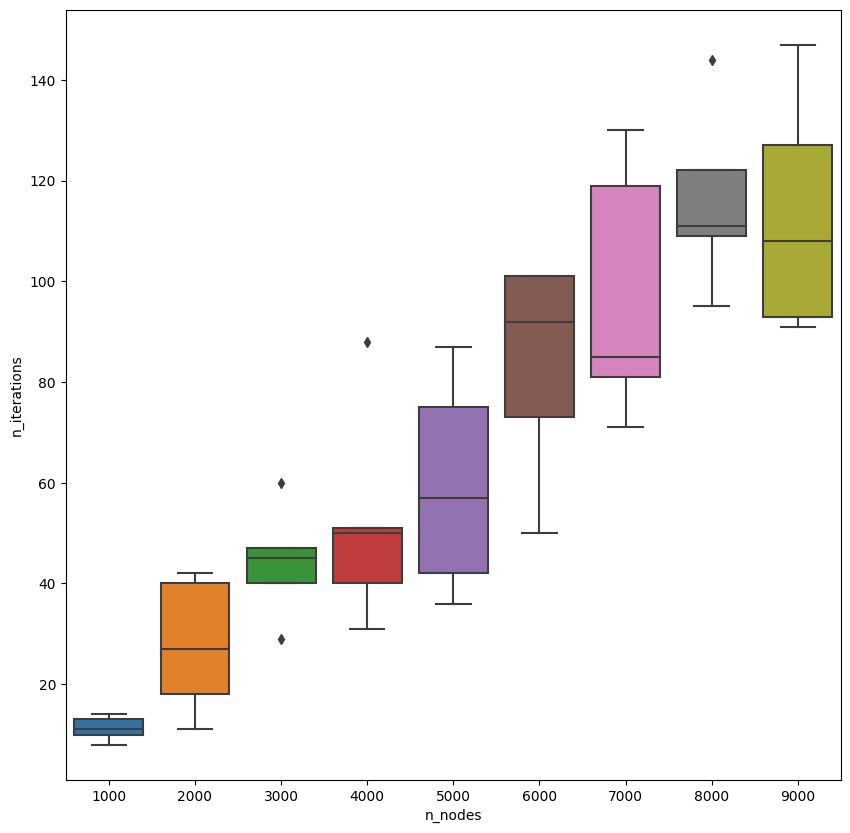

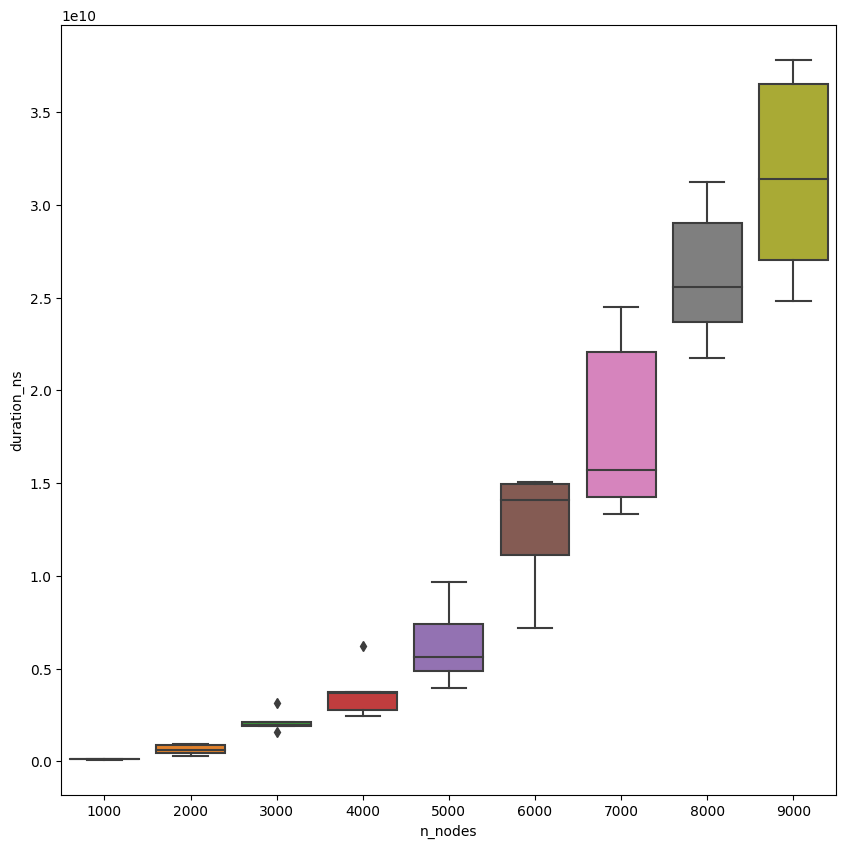

In [357]:
results_df = pd.DataFrame(n_nodes_results)
plots = []
for col in results_df.drop(["networkx_maximum_flow", "objective_value"], axis=1):
    df = results_df[col].explode().reset_index()
    df = df.rename(columns={"index": "n_nodes"})
    df["n_nodes"] += 1
    df["n_nodes"] *= 1000

    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.boxplot(
        data=df,
        x="n_nodes",
        y=col,
        ax=ax,
    )
    plt.savefig(f"n_nodes_{col}.png")

### Edge density

In [396]:
min_capacity = 5
max_capacity = 15
density = 0.005
n_nodes = 1000
n_edges = int(density * (n_nodes * (n_nodes - 1)))
source, destination = 0, 1  # don't need to randomize (graph is randomized)
precision = 4
max_iter = 1000
solver = pl.GUROBI(msg=False)
n_nodes, n_edges

(1000, 4995)

In [ ]:
vals = np.arange(0.005, 0.05, 0.001)
params = [
    {"n_nodes": n_nodes, "n_edges": int(density * (n_nodes * (n_nodes - 1)))}
    for density in vals
]
n_nodes_results = run_n_times(
    params=params,
    n=5,
)

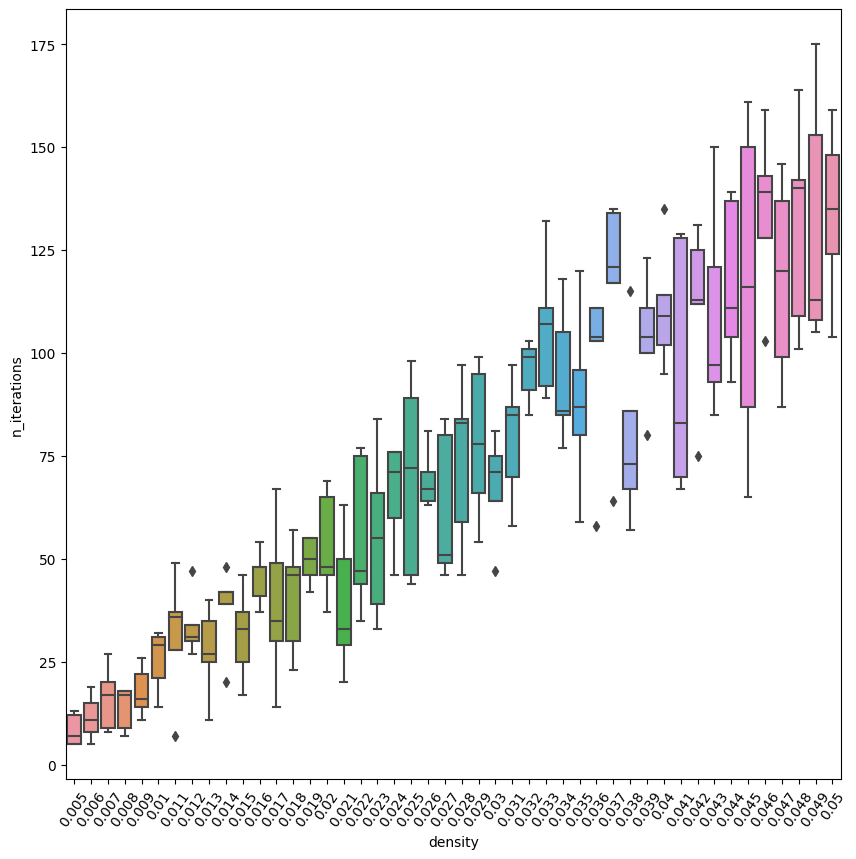

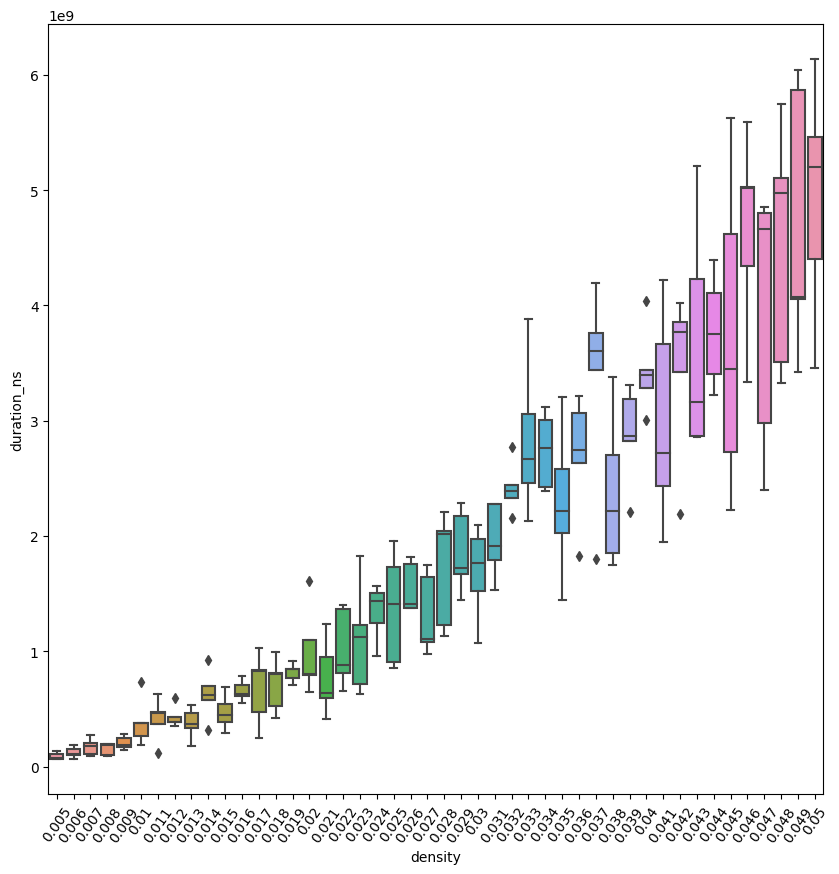

In [421]:
results_df = pd.DataFrame(n_nodes_results)
plots = []
for col in results_df.drop(["networkx_maximum_flow", "objective_value"], axis=1):
    df = results_df[col].explode().reset_index()
    df["density"] = np.around(np.repeat(vals, 5), 3)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.boxplot(
        data=df,
        x="density",
        y=col,
        ax=ax,
    )
    plt.xticks(rotation=55)
    plt.savefig(f"density_{col}.png")